In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import yasa
import seaborn as sns
import ghibtools as gh
import mne
import glob
import time
import datetime
import yasa
from scipy import signal
import json
from params import *

In [2]:
subject = 'S4'

In [3]:
data = xr.open_dataarray(f'../preproc/{subject}_reref.nc') # load preprocessed data (lazy load)

In [4]:
sig = data.sel(chan = 'Fp2').data

butter iirfilter of 4th-order
btype : bandpass


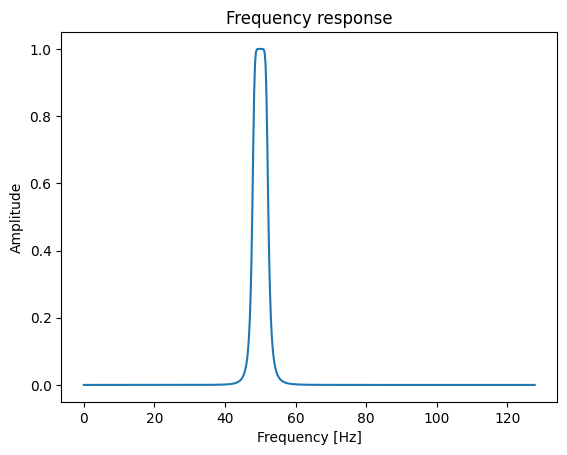

array([-0.05167957,  1.46482288,  0.99245232, ..., -0.00554558,
       -0.01124239, -0.00201876])

In [5]:
gh.iirfilt(sig, srate, lowcut = 48 , highcut = 52, verbose = True, show = True)

In [6]:
def complex_mw(time, n_cycles , freq, a= 1, m = 0): 
    """
    time : time vector of the wavelet
    n_cycles : number of cycles in the wavelet
    freq : frequency of the wavelet
    a : amplitude of the wavelet
    m : x center of the wavelet
    """
    s = n_cycles / (2 * np.pi * freq)
    GaussWin = a * np.exp( -(time - m)** 2 / (2 * s**2)) # real gaussian window
    complex_sinewave = np.exp(1j * 2 *np.pi * freq * time) # complex sinusoidal signal
    cmw = GaussWin * complex_sinewave
    return cmw

In [7]:
tmw = np.arange(-2,2,1/srate)
mw = complex_mw(tmw, n_cycles = 30, freq= 20)

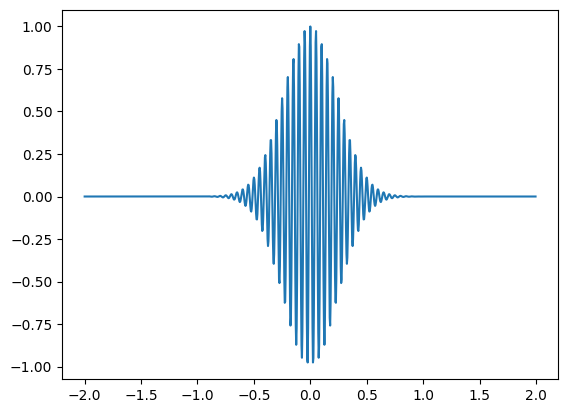

In [8]:
fig, ax = plt.subplots()
ax.plot(tmw, np.real(mw))

In [9]:
def morlet_family(srate, f_start, f_stop, n_step, n_cycles, show = False):
    tmw = np.arange(-20,20,1/srate)
    freqs = np.linspace(f_start,f_stop,n_step) 
    mw_family = np.zeros((freqs.size, tmw.size), dtype = 'complex')
    for i, fi in enumerate(freqs):
        mw_family[i,:] = complex_mw(tmw, n_cycles = n_cycles, freq = fi)
    if show:
        fig, ax = plt.subplots()
        im = ax.pcolormesh(tmw, freqs, np.real(mw_family))
        ax.set_ylabel('Freq [Hz]')
        ax.set_xlabel('Time')
        fig.colorbar(im)
        plt.show()
    return freqs, mw_family

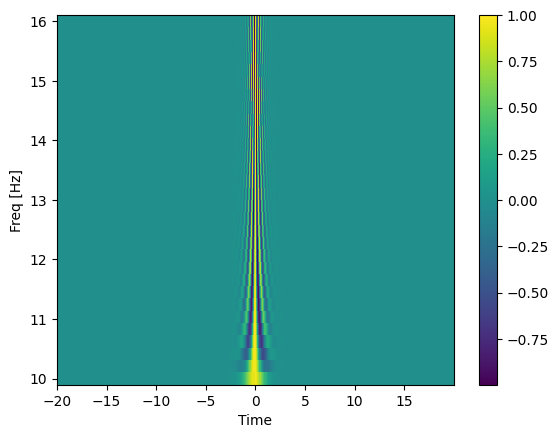

In [10]:
freq , family = morlet_family(srate, f_start = 10, f_stop = 16, n_step = 30, n_cycles = 50, show = True)

In [11]:
t_target = 10000
delta = 15
t_start = t_target - delta
t_stop = t_target + delta
sig = data.sel(chan = 'Fp2', time = slice(t_start,t_stop)).data

In [12]:
def compute_tf(sig, srate, f_start, f_stop, n_step, n_cycles):
    freqs, family = morlet_family(srate, f_start = f_start, f_stop = f_stop, n_step = n_step, n_cycles = n_cycles)
    tf = np.zeros((family.shape[0], sig.size), dtype = 'complex')
    for i in range(family.shape[0]):
        mw = family[i,:]
        tf[i,:] = signal.fftconvolve(sig, mw, mode = 'same')
    return freqs , np.abs(tf)

In [13]:
def compute_tf_fast(sig, srate, f_start, f_stop, n_step, n_cycles, feature = 'module', exponent = 1):
    freqs, family = morlet_family(srate, f_start = f_start, f_stop = f_stop, n_step = n_step, n_cycles = n_cycles)
    tf = np.zeros((family.shape[0], sig.size), dtype = 'complex')
    sigs = np.tile(sig, (n_step,1))
    tf = signal.fftconvolve(sigs, family, mode = 'same', axes = 1)
    if feature == 'module':
        return freqs , np.abs(tf) ** exponent
    elif feature == 'real':
        return freqs , np.real(tf) ** exponent

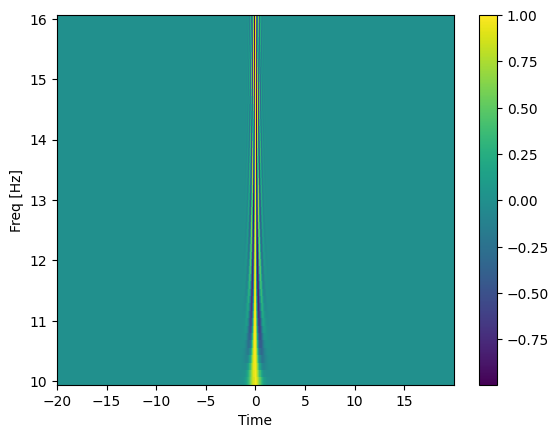

In [14]:
f_start = 10
f_stop = 16
n_step = 50
n_cycles = 30
freq, family = morlet_family(srate, f_start = f_start, f_stop = f_stop, n_step = n_step, n_cycles = n_cycles, show = True)
f_fast = np.linspace(f_start,f_stop,n_step) 
t = np.arange(0, sig.size/srate, 1 / srate)

tf_fast = np.zeros((family.shape[0], sig.size), dtype = 'complex')
for i in range(family.shape[0]):
    mw = family[i,:]
    tf_fast[i,:] = signal.fftconvolve(sig, mw, mode = 'same', axes = 0)

0.05740040517412126
srate down 51.2
0.009454818908125162
ratio duration 6.071021109118571


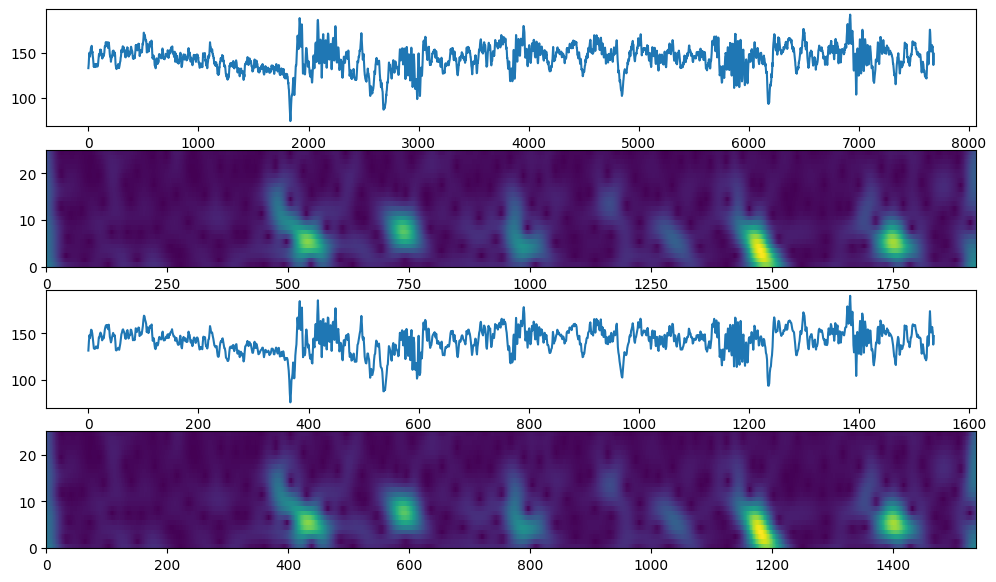

In [15]:
fig, axs = plt.subplots(nrows = 4, figsize = (12,7))
ax = axs[0]
ax.plot(sig)
ax = axs[1]
t1 = time.perf_counter()
f, tf = compute_tf_fast(sig, srate, f_start=10 , f_stop = 16 , n_step = 25, n_cycles = 20)
t2 = time.perf_counter()
duration_full = t2 - t1
print(duration_full)
ax.pcolormesh(signal.decimate(tf, q=4))

factor = 5
srate_down = srate / factor
sig_decimate = signal.decimate(sig, q=factor)
ax = axs[2]
ax.plot(sig_decimate)
ax = axs[3]
t1 = time.perf_counter()
f, tf = compute_tf_fast(sig_decimate, srate_down, f_start=10 , f_stop = 16 , n_step = 25, n_cycles = 20)
print('srate down', srate_down)
t2 = time.perf_counter()
duration_down = t2 - t1
print(duration_down)
ratio_duration = duration_full / duration_down
print('ratio duration', ratio_duration)
ax.pcolormesh(tf)


In [16]:
t_target = 10060
delta = 15
t_start = t_target - delta
t_stop = t_target + delta
ind_start = int(t_start * srate)
ind_stop = int(t_stop * srate)
# sig = data.sel(chan = 'Fp1', time = slice(t_start,t_stop)).data
sig = data[0,ind_start:ind_stop].data

marker_t = 4434.9

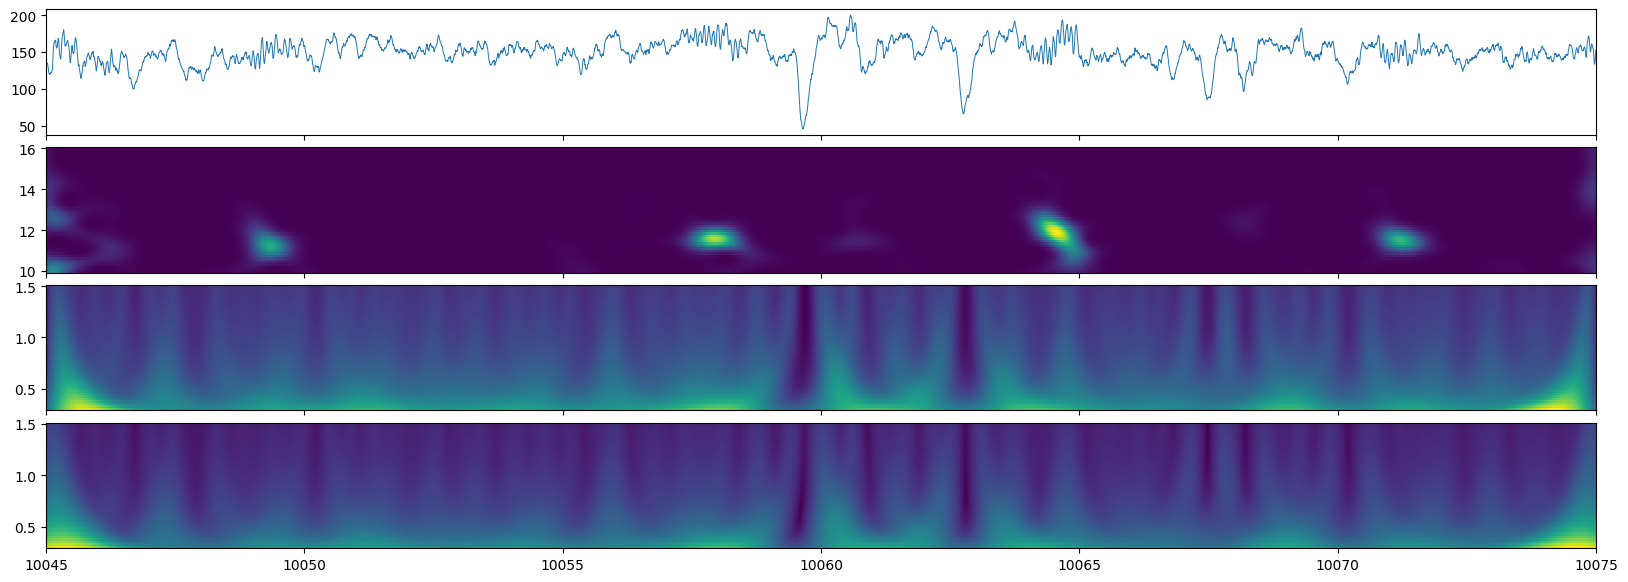

In [17]:
fig, axs = plt.subplots(nrows = 4, figsize = (20,7), sharex = True)
fig.subplots_adjust(hspace = 0.1)

t = np.arange(t_start, t_stop, 1 /srate)

ax = axs[0]
ax.plot(t,sig, lw = 0.7)
ax.set_xlim(t_start, t_stop)
ax.axvline(x = marker_t, color = 'r')

ax = axs[1]
f, tf = compute_tf_fast(sig, srate, f_start=10 , f_stop = 16 , n_step = 50, n_cycles = 25, feature = 'module', exponent = 3)
ax.pcolormesh(t, f , tf)

ax = axs[2]
f, tf = compute_tf_fast(sig, srate, f_start=0.3 , f_stop = 1.5 , n_step = 50, n_cycles = 2, feature = 'real', exponent = 1)
ax.pcolormesh(t,f,tf)

ax = axs[3]
f, tf = compute_tf_fast(sig, srate, f_start=0.3 , f_stop = 1.5 , n_step = 50, n_cycles = 2, feature = 'module', exponent = 1)
ax.pcolormesh(t,f,tf)

In [20]:
t, out = yasa.moving_transform(sig, sf = srate, method = 'rms', interp = True)

In [21]:
t.shape

(7680,)

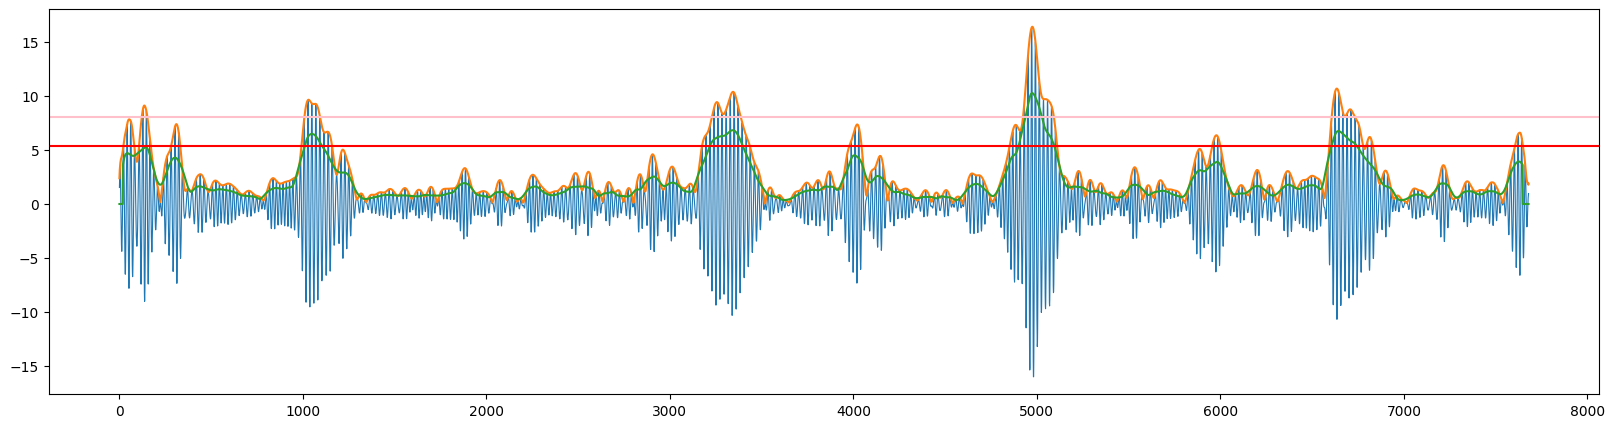

In [22]:
sigma = gh.iirfilt(sig, srate, 11,16)
sigma_env = gh.get_amp(sigma)
t, out = yasa.moving_transform(sigma, sf = srate, method = 'rms', interp = True)

fig, ax = plt.subplots(figsize = (20,5))
ax.plot(sigma, lw = 0.8)
ax.plot(sigma_env)
ax.plot(out)
ax.axhline(y = np.std(out) * 3, color = 'r')
ax.axhline(y = gh.mad(sigma) * 5, color = 'pink')

In [23]:
test_sig = data.loc['Fz',:].values
sigma_test = gh.iirfilt(test_sig, srate, 11 ,16)
sigma_env_test = gh.get_amp(sigma_test)
t, rms = yasa.moving_transform(sigma_test, sf = srate, method = 'rms', interp = True)

In [24]:
broad_sig =  gh.iirfilt(test_sig, srate, 1 ,30)

In [25]:
t, corr =  yasa.moving_transform(x = sigma_test, y = broad_sig, sf = srate, method = 'corr', interp = True)

In [26]:
%matplotlib widget

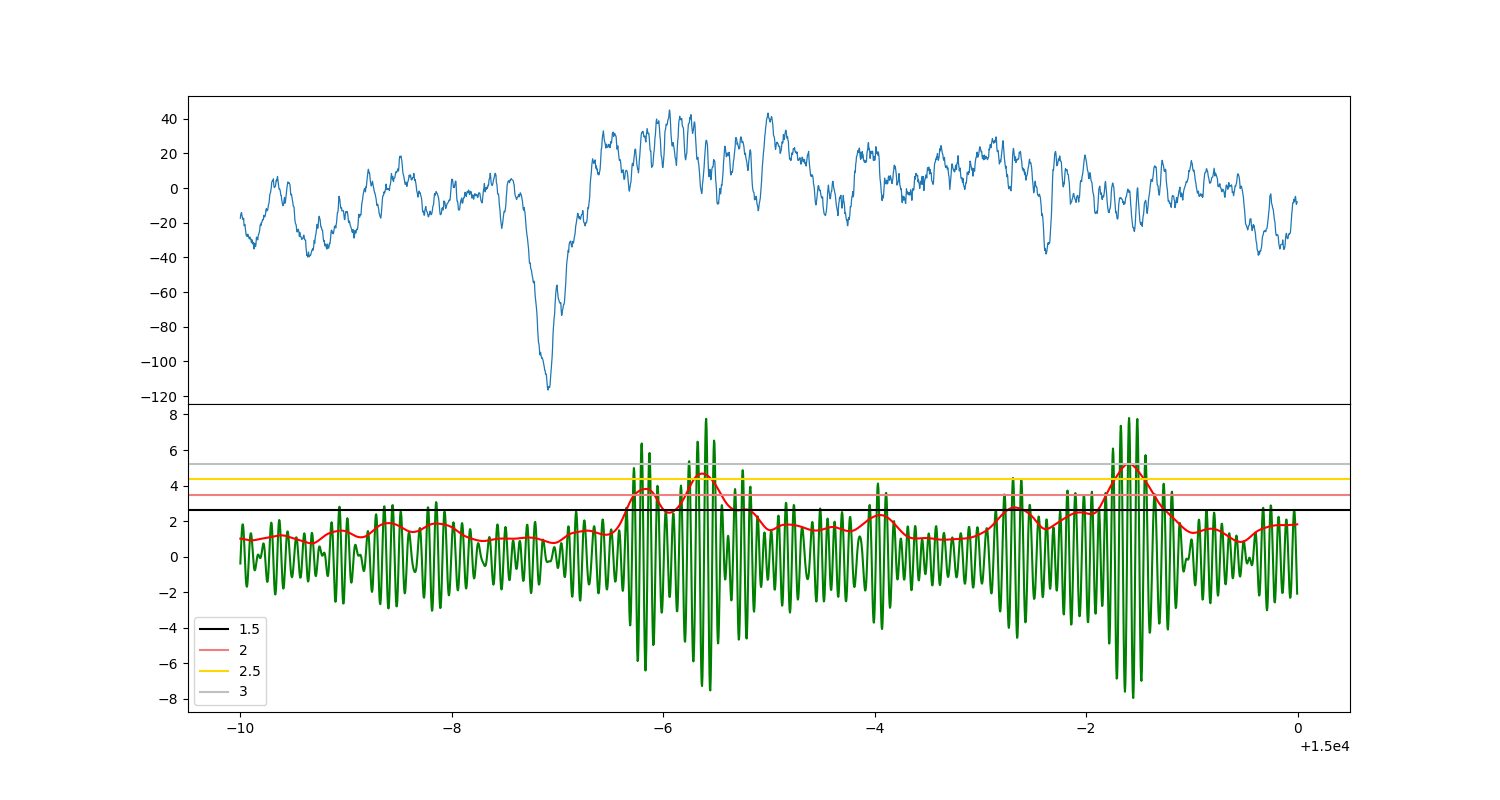

In [49]:
# n_rms = 1.5
# n_mads = 3

start = 14990
stop = 15000
start_ind = int(srate * start)
stop_ind = int(srate * stop)


fig, axs = plt.subplots(nrows = 2, figsize = (15,8), sharex = True)
fig.subplots_adjust(hspace = 0)


ax = axs[0]
ax.plot(t[start_ind:stop_ind], test_sig[start_ind:stop_ind] - np.mean(test_sig), lw = 0.9, color = 'tab:blue')
# ax.plot(t[start_ind:stop_ind], broad_sig[start_ind:stop_ind], color = 'c')

ax = axs[1]
ax.plot(t[start_ind:stop_ind], sigma_test[start_ind:stop_ind], color = 'g')
ax.plot(t[start_ind:stop_ind], rms[start_ind:stop_ind], color = 'red')
# ax.plot(t, sigma_env_test, color = 'g')
for n_rms, color  in zip([1.5  , 2 , 2.5, 3],['black','lightcoral','gold', 'silver']):
    ax.axhline(np.std(rms) * n_rms, label = n_rms, color=color)
ax.legend()
# ax.axhline(gh.mad(sigma_env_test) * n_mads, color = 'g')

# ax.set_xlim(15000,15200)

In [ ]:
sigma = gh.iirfilt(sig, srate, 11 , 16, show = False)
env = gh.get_amp(sigma)
mad = gh.mad(env)

In [ ]:
fig, ax = plt.subplots()
# ax.plot(sig)
ax.plot(sigma)
ax.plot(env)
ax.axhline(y = mad  * 3, color = 'red')

In [ ]:
def get_sigma_env(sig, srate, lowcut = 11, highcut = 16):
    sigma = gh.iirfilt(sig, srate, lowcut, highcut)
    sigma_env = gh.get_amp(sigma)
    return sigma_env

In [ ]:
def detect_sigma_bursts(env, n_mads):
    rises, = np.where((env[:-1] <=n_mads) & (env[1:] >n_mads)) # detect where crossing n_mads but rising
    decays, = np.where((env[:-1] >=n_mads) & (env[1:] <n_mads)) # detect where crossing n_mads but decaying
    if rises[0] > decays[0]: # first point detected has to be a rise
        decays = decays[1:] # so remove the first decay if is before first rise
    if rises[-1] > decays[-1]: # last point detected has to be a decay
        rises = rises[:-1] # so remove the last rise if is after last decay

    return pd.DataFrame.from_dict({'rises':rises, 'decays':decays}, orient = 'index').T

In [ ]:
def compute_sigma_bursts_features(sigma_env, sigma_bursts, srate):
    features = []
    for i , row in sigma_bursts.iterrows(): # last cycle is probably not complete so it is removed in any case
        if i != sigma_bursts.index[-1]:
            
            start_ind = int(row['rises'])
            stop_ind = int(row['decays'])
            
            start_t = start_ind / srate
            stop_t = stop_ind / srate
            
            burst_duration = stop_t - start_t
            peak_ind, = np.nonzero(sigma_env == np.max(sigma_env[start_ind:stop_ind]))[0]
            peak_t = peak_ind / srate
            
            features.append([start_ind, stop_ind, start_t, stop_t, burst_duration,peak_ind, peak_t])
    df_features = pd.DataFrame(features, columns = ['start_ind','stop_ind','start_t','stop_t','burst_duration','peak_ind','peak_t'])
    return df_features     

In [ ]:
def clean_bursts(burst_features, min_duration=0.5, max_duration=3):
    return burst_features[(burst_features['burst_duration'] > min_duration) & (burst_features['burst_duration'] < max_duration)].reset_index(drop = True)

In [ ]:
def detect_spindles(sig, srate, n_mads=5, sigma_low=11, sigma_high=16, min_duration=0.5, max_duration = 3):
    sigma_env = get_sigma_env(sig, srate, sigma_low, sigma_high)
    sigma_bursts = detect_sigma_bursts(sigma_env, n_mads)
    sigma_bursts_features = compute_sigma_bursts_features(sigma_env, sigma_bursts, srate)
    clean_sigma_bursts_features = clean_bursts(sigma_bursts_features, min_duration=min_duration, max_duration=max_duration)
    return clean_sigma_bursts_features

In [ ]:
data

In [ ]:
def eeg_da_spindles(da, srate, n_mads=5, sigma_low=11, sigma_high=16, min_duration=0.5, max_duration = 3, computing_chans = None, verbose=False):
    chan_spindles_concat = []
    if computing_chans is None:
        chans = da.coords['chan'].values
    else:
        chans = computing_chans
    for chan in chans:
        if verbose:
            print(chan)
        sig = da.loc[chan,:].data
        spindles = detect_spindles(sig, srate, n_mads, sigma_low, sigma_high, min_duration, max_duration)
        spindles['channel'] = chan
        chan_spindles_concat.append(spindles)
    return pd.concat(chan_spindles_concat)

In [ ]:
all_spindles = eeg_da_spindles(data, srate, computing_chans = sigma_power_chans, verbose = True)

In [ ]:
plt.figure()
all_spindles['burst_duration'].plot.hist(bins = 200)
plt.show()

In [ ]:
rsp_features = pd.read_excel('/crnldata/cmo/Etudiants/NBuonviso2022_Sleep_EEG_Respi_Valentin/resp_features/S4_resp_features_tagged.xlsx', index_col = 0)

In [ ]:
def crosscorrelogram(a,b):
    """
    Compute combinatorial difference between a vs b (a - b with all possibilities)
    
    ------------------
    INPUTS :
    a : 1D numpy vector
    b : 1D numpy vector
    
    OUTPUT :
    c : crosscorrelogram vector of shape (a.size*b.size,)
    
    """
    c = a[:, np.newaxis] - b[np.newaxis, :]
    return c.reshape(-1)

In [ ]:
cross_co = crosscorrelogram(all_spindles[all_spindles['channel'] == 'Fz']['start_t'].values, rsp_features['start_time'].values)

In [ ]:
cross_co

In [ ]:
%matplotlib inline

In [ ]:
all_spindles

In [ ]:
delta = 2
delta_t_by_bin = 0.2
nbins = int(delta * 2 / delta_t_by_bin)
fig, axs = plt.subplots(ncols = len(sigma_power_chans), figsize = (15,2))
for c, chan in enumerate(sigma_power_chans):
    ax = axs[c]
    cross_co = crosscorrelogram(all_spindles[all_spindles['channel'] == chan]['start_t'].values, rsp_features['stop_time'].values)
    cross_sel = cross_co[(cross_co < delta) & (cross_co > -delta)]
    ax.hist(cross_sel, bins = nbins, align = 'mid')
    ax.set_title(chan)
    ax.set_xlim(-delta,delta)
plt.show()

In [ ]:
fig, ax = plt.subplots()
# ax.plot(sig)
ax.plot(sigma)
ax.plot(env)
ax.axhline(y = mad  * n_mads, color = 'red')
for i, row in spindles.iterrows():
    ax.axvline(x = row['start_ind'], color = 'r')
    ax.axvline(x = row['stop_ind'], color = 'm')
    ax.axvline(x = row['peak_ind'], color = 'y')

In [ ]:
test_sig = data.loc['Fz',:].values

In [ ]:
spindles = detect_spindles(test_sig, srate)

In [ ]:
spindles

In [ ]:
spindles['burst_duration'].plot.hist(bins = 50)

In [ ]:
%matplotlib widget

In [ ]:
fig, ax = plt.subplots(figsize = (15,5))
# ax.plot(sig)
ax.plot(test_sig)
# ax.axhline(y = mad  * 5, color = 'red')
for i, row in spindles.iterrows():
    ax.axvline(x = row['start_ind'], color = 'r')
    ax.axvline(x = row['stop_ind'], color = 'm')
    ax.axvline(x = row['peak_ind'], color = 'y')

In [ ]:
crossings

In [ ]:
n_mads = 5
fig, ax = plt.subplots()
# ax.plot(sig)
ax.plot(sigma)
ax.plot(env)

rises, = np.where((env[:-1] <=mad * n_mads) & (env[1:] > mad * n_mads)) # detect where sign inversion from - to +
decays, = np.where((env[:-1] >=mad * n_mads) & (env[1:] < mad * n_mads)) # detect where sign inversion from + to -
ax.axhline(y = mad  * n_mads, color = 'red')
for rise in rises:
    ax.axvline(x = rise, color = 'g')
for decay in decays:
    ax.axvline(x = decay, color = 'y')

In [ ]:
inds = np.nonzero(env > 3 * mad)[0]

In [ ]:
inds.shape

In [ ]:
mad = gh.mad(env**2)

In [ ]:
mad

In [ ]:
spindles = pd.read_excel(f'../event_detection/{subject}_spindles_reref_yasa.xlsx', index_col = 0)

In [ ]:
spindles

In [ ]:
def spindle_speed(freq, threshold):
    if freq <= threshold:
        return 'SS'
    elif freq > threshold:
        return 'FS'

In [ ]:
sp_speeds = []
for i, row in spindles.iterrows():
    sp_speeds.append(spindle_speed(freq=row['Frequency'], threshold=spindles_freq_threshold[subject]))

In [ ]:
spindles['Spindle_Speed'] = sp_speeds

In [ ]:
spindles

In [ ]:
pd.crosstab(spindles['Spindle_Speed'], spindles['Channel'])

In [ ]:
a = np.random.rand(1000) * 100

In [ ]:
a.shape

In [ ]:
def crosscorrelogram(a,b):
    """
    Compute combinatorial difference between a vs b (a - b with all possibilities)
    
    ------------------
    INPUTS :
    a : 1D numpy vector
    b : 1D numpy vector
    
    OUTPUT :
    c : crosscorrelogram vector of shape (a.size*b.size,)
    
    """
    c = a[:, np.newaxis] - b[np.newaxis, :]
    return c.reshape(-1)

In [ ]:
subject = 'S1'

In [ ]:
spindles = pd.read_excel(f'../event_detection/{subject}_spindles_reref_yasa.xlsx', index_col = 0)
slowwaves = pd.read_excel(f'../event_detection/{subject}_slowwaves_reref_yasa.xlsx', index_col = 0)

In [ ]:
delta = 5
delta_t_by_bin = 0.05
nbins = int(delta * 2 / delta_t_by_bin)
print(nbins)

chans = [chan for chan in spindles['Channel'].unique() if not chan in ['T4','T3','O1','O2']]
stages = ['N2','N3']

nrows = len(stages)
ncols = len(chans)

fig, axs = plt.subplots(nrows, ncols, figsize = (20,5), constrained_layout = True)

for c, ch in enumerate(chans):
    for r, stage in enumerate(stages):
        
        sp = spindles[(spindles['Channel'] == ch) & (spindles['Stage_Letter'] == stage)]
        sw = slowwaves[(slowwaves['Channel'] == ch) & (slowwaves['Stage_Letter'] == stage)]
        cross = crosscorrelogram(sp['Peak'].values, sw['NegPeak'].values)
        cross_sel = cross[(cross < delta) & (cross > -delta)]
        N = cross_sel.size
        
        ax = axs[r,c]
        ax.set_title(f'{ch} - {stage} - N : {N}')
        ax.hist(cross_sel, bins = nbins, align = 'mid')
        ax.set_xlim(-delta,delta)
        
plt.show()

In [ ]:
slowwaves[(slowwaves['NegPeak'] >  19974) & (slowwaves['NegPeak'] < 19976)]

In [ ]:
(slowwaves['NegPeak'] - slowwaves['Start']).mean()

In [ ]:
(slowwaves['End'] - slowwaves['NegPeak']).mean()

In [ ]:
def cooccuring_sp_sw_df(spindles, slowwaves):
    features_cooccuring_sp = []
    sw_with_spindle_inside = []
    for ch in slowwaves['Channel'].unique():
        for stage in slowwaves['Stage_Letter'].unique():
            sw_staged_ch = slowwaves[(slowwaves['Channel'] == ch)&(slowwaves['Stage_Letter'] == stage)]
            sp_staged_ch = spindles[(spindles['Channel'] == ch)&(spindles['Stage_Letter'] == stage)]

            if not sw_staged_ch.shape[0] == 0:
                for i, row in sw_staged_ch.iterrows():

                    start_window = row['Start']
                    stop_window = row['End']
                    negpeak = row['NegPeak']
                    duration = row['Duration']

                    co_occuring_spindles = sp_staged_ch[(sp_staged_ch['Peak'] >= start_window) & (sp_staged_ch['Peak'] < stop_window)]
                    
                    if not co_occuring_spindles.shape[0] == 0:
                        sw_with_spindle_inside.append(i)
                        for s, sp in co_occuring_spindles.iterrows():

                            t = sp['Peak']
                            cooccuring_with_sw = True
                            absolute_t_vs_negpeak = t - negpeak
                            absolute_t_vs_start = t - start_window
                            relative_t_vs_duration = absolute_t_vs_start / duration
                            features_cooccuring_sp.append([s, cooccuring_with_sw, absolute_t_vs_negpeak, absolute_t_vs_start, relative_t_vs_duration])
                            
                            
                        
    cooccurors = pd.DataFrame(features_cooccuring_sp, columns = ['index','in_slowwave','t_vs_NegPeak_sw','t_vs_Start_sw','relative_t_in_sw']).set_index('index')
    
    sp_return = spindles.reindex(columns = list(spindles.columns) + list(cooccurors.columns))
    sp_return.loc[cooccurors.index,cooccurors.columns] = cooccurors
    sp_return.loc[:,'in_slowwave'] = sp_return['in_slowwave'].fillna(False)
    
    slowwaves_return = slowwaves.copy()
    slowwaves_return['sp_inside'] = np.nan
    slowwaves_return.loc[sw_with_spindle_inside, 'sp_inside'] = True
    slowwaves_return.loc[:,'sp_inside'] = slowwaves_return['sp_inside'].fillna(False)
    
    return sp_return, slowwaves_return

In [ ]:
sp, sw = cooccuring_sp_sw_df(spindles, slowwaves)

In [ ]:
sp

In [ ]:
sw

In [ ]:
pd.crosstab(sw['Stage_Letter'], sw['sp_inside'])

In [ ]:
sp['Frequency'] > spindles_freq_threshold[subject]

In [ ]:
sp_speed = sp.copy()
sp_speed['Sp_Speed'] = np.nan
sp_speed.loc[:,'Sp_Speed'] = (sp['Frequency'] > spindles_freq_threshold[subject]).map({False:'SS',True:'FS'})

In [ ]:
sp_speed

In [ ]:
sp_speed['Sp_Speed'].value_counts()

In [ ]:
spindles = pd.read_excel(f'../event_detection/{subject}_spindles_cooccuring.xlsx', index_col = 0)

In [ ]:
spindles

In [ ]:
pd.crosstab(spindles['in_slowwave'], spindles['Sp_Speed'])

In [ ]:
spindles.columns

In [ ]:
for metric in ['Duration', 'Amplitude', 'RMS', 'AbsPower',
       'RelPower', 'Frequency', 'Oscillations', 'Symmetry']:
    sns.boxplot(data = spindles, x = 'Sp_Speed', y = metric, hue = 'in_slowwave')
    plt.show()

In [ ]:
spindles

In [ ]:
sp_staged = spindles[spindles['Stage_Letter'].isin(['N2','N3'])]

In [ ]:
pd.crosstab(index = [ sp_staged['Sp_Speed'], sp_staged['Channel']] , columns = [ sp_staged['in_slowwave'], sp_staged['Stage_Letter']], normalize = False)

In [ ]:
%matplotlib inline

In [ ]:
fig, ax = plt.subplots(figsize = (15,7))
pd.crosstab(index = [ sp_staged['Sp_Speed'], sp_staged['Channel']] , columns = [ sp_staged['in_slowwave'], sp_staged['Stage_Letter']], normalize = False).plot.bar(stacked = True, ax=ax)

In [ ]:
%matplotlib widget

In [ ]:
def filter_sig(sig, srate, lowcut=None, highcut=None, order = 4, ftype = 'butter', verbose = False, show = False):
        
    if lowcut is None and not highcut is None:
        btype = 'lowpass'
        cut = highcut
        
    if not lowcut is None and highcut is None:
        btype = 'highpass'
        cut = lowcut
        
    if not lowcut is None and not highcut is None:
        btype = 'bandpass'
        
    if btype in ('bandpass', 'bandstop'):
        band = [lowcut, highcut]
        assert len(band) == 2
        Wn = [e / srate * 2 for e in band]
    else:
        Wn = float(cut) / srate * 2
        
    filter_mode = 'sos' 
    sos = signal.iirfilter(order, Wn, analog=False, btype=btype, ftype=ftype, output=filter_mode)
    filtered_sig = signal.sosfiltfilt(sos, sig, axis=0)
    if verbose:
        print(f'{ftype} iirfilter of {order}th-order')
        print(f'btype : {btype}')
        
            
    if show:
        w, h = signal.sosfreqz(sos,fs=srate)
        fig, ax = plt.subplots()
        ax.plot(w, np.abs(h))
        ax.set_title('Frequency response')
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('Amplitude')
        plt.show()
        
    return filtered_sig

In [ ]:
subject = 'S10'

In [ ]:
data = xr.open_dataarray(f'../preproc/{subject}_reref.nc') # load preprocessed data (lazy load)

In [ ]:
# rsp = data.sel(chan = 'DEBIT', time = slice(10,3000)).values
rsp = data.sel(chan = 'DEBIT').values

In [ ]:
def detect_zerox(sig):
    rises, = np.where((sig[:-1] <=0) & (sig[1:] >0)) # detect where sign inversion from - to +
    decays, = np.where((sig[:-1] >=0) & (sig[1:] <0)) # detect where sign inversion from + to -
    if rises[0] > decays[0]: # first point detected has to be a rise
        decays = decays[1:] # so remove the first decay if is before first rise
    if rises[-1] > decays[-1]: # last point detected has to be a decay
        rises = rises[:-1] # so remove the last rise if is after last decay
    return pd.DataFrame.from_dict({'rises':rises, 'decays':decays}, orient = 'index').T

def get_cycle_features(zerox, sig, srate):
    features = []
    for i , row in zerox.iterrows(): # last cycle is probably not complete so it is removed in any case
        if i != zerox.index[-1]:
            start = int(row['rises'])
            transition = int(row['decays'])
            stop = int(zerox.loc[i+1, 'rises'])
            start_t = start / srate
            transition_t = transition / srate
            stop_t = stop / srate
            cycle_duration = stop_t - start_t
            inspi_duration = transition_t - start_t
            expi_duration = stop_t - transition_t
            cycle_freq = 1 / cycle_duration
            cycle_ratio = inspi_duration / cycle_duration
            inspi_amplitude = np.max(np.abs(sig[start:transition]))
            expi_amplitude = np.max(np.abs(sig[transition:stop]))
            cycle_amplitude = inspi_amplitude + expi_amplitude
            inspi_volume = np.trapz(np.abs(sig[start:transition]))
            expi_volume = np.trapz(np.abs(sig[transition:stop]))
            cycle_volume = inspi_volume + expi_volume
            second_volume = cycle_freq * cycle_volume
            features.append([start, transition , stop, start_t, transition_t, stop_t, cycle_duration,
                             inspi_duration, expi_duration, cycle_freq, cycle_ratio, inspi_amplitude,
                             expi_amplitude,cycle_amplitude, inspi_volume, expi_volume, cycle_volume, second_volume])
    df_features = pd.DataFrame(features, columns = ['start','transition','stop','start_time','transition_time',
                                                    'stop_time','cycle_duration','inspi_duration','expi_duration','cycle_freq','cycle_ratio',
                                                    'inspi_amplitude','expi_amplitude','cycle_amplitude','inspi_volume','expi_volume','cycle_volume','second_volume'])
    return df_features

def zscore(sig):
    return (sig - np.median(sig)) / np.std(sig)

def get_resp_features(rsp, srate):
    zerox = detect_zerox(rsp)
    features = get_cycle_features(zerox, rsp, srate)
    return features

In [ ]:
resp_filtered = filter_sig(rsp, srate, None, 1.5, order = 4, show = True) # filtering signal
resp_filtered_zscored = zscore(resp_filtered)
resp_features = get_resp_features(resp_filtered_zscored - 0.02, srate) # compute resp features 

In [ ]:
cols = ['cycle_duration', 'inspi_duration', 'expi_duration',
       'cycle_freq', 'cycle_ratio', 'inspi_amplitude', 'expi_amplitude','cycle_amplitude',
       'inspi_volume', 'expi_volume','cycle_volume','second_volume']

In [ ]:
nrows = 4
ncols = 3
col_grid = np.array(cols).reshape(4,3)
bins = int(resp_features.shape[0] / 20)
fig, axs = plt.subplots(nrows, ncols, figsize = (13,5), constrained_layout = True)
for r in range(nrows):
    for c in range(ncols):
        colname = col_grid[r,c]
        ax = axs[r,c]
        ax.hist(resp_features[colname].values, bins=bins)
        ax.set_title(colname)

In [ ]:
def cleaning_resp_features(resp_features, verbose= True):
    keep_second_volume = resp_features['second_volume'] > 20
    keep_cycle_ratio = resp_features['cycle_ratio'] < 0.6
    keep_duration = (resp_features['cycle_duration'] > 1) & (resp_features['cycle_duration'] < 15)
    keep = keep_second_volume & keep_cycle_ratio
    removed = ~ keep
    clean_resp_features = resp_features[keep]
    if verbose:
        n_removed = resp_features.shape[0] - clean_resp_features.shape[0]
        print(f'{n_removed} cycles removed')
    return clean_resp_features

In [ ]:
fig, ax = plt.subplots(figsize = (15,7))

clean_resp_features = cleaning_resp_features(resp_features)

starts = clean_resp_features['start']
transitions = clean_resp_features['transition']

ax.plot(rsp)
ax.plot(starts, rsp[starts], 'o', color = 'r')
ax.plot(transitions, rsp[transitions], 'o', color = 'g')

ax2 = ax.twinx()
ax2.plot(resp_filtered_zscored, color = 'darkorange')
ax2.plot(starts, resp_filtered_zscored[starts], 'x', color = 'r')
ax2.plot(transitions, resp_filtered_zscored[transitions], 'x', color = 'g')

In [ ]:
concat_rsp_features = []
for subject in subjects: # loop on subjects
    df_subject = pd.read_excel(f'../resp_features/{subject}_resp_features_tagged.xlsx', index_col = 0) # load rsp features tagged by staging and presence of events in resp cycles
    df_subject.insert(0, 'subject', subject) # insert subject id a first column
    concat_rsp_features.append(df_subject) # append rsp features of the subject to a list
pooled_features = pd.concat(concat_rsp_features)

In [ ]:
pooled_features

In [ ]:
sns.boxplot(data = pooled_features, x = 'sleep_stage', y = 'second_volume')

In [ ]:
for stage in pooled_features['sleep_stage'].unique():
    pooled_features_stage = pooled_features[pooled_features['sleep_stage'] == stage]
    fig, ax = plt.subplots()
    ax.hist(pooled_features_stage['second_volume'] , bins = 200)
    ax.set_title(stage)
    plt.show()

In [ ]:
from scipy import stats

In [ ]:
density = stats.gaussian_kde(pooled_features['second_volume'].values)

In [ ]:
xs = np.linspace(0,800,500)
density.covariance_factor = lambda : .01
density._compute_covariance()

In [ ]:
def get_kde(x, maximum = None, bw_adjust = 0.01, n_points=200):
    if maximum is None:
        xs = np.linspace(0,max(x),n_points)
    else:
        xs = np.linspace(0,maximum,n_points)
    density = stats.gaussian_kde(x)
    density.covariance_factor = lambda : bw_adjust
    density._compute_covariance()
    return xs, density(xs)

In [ ]:
fig, ax = plt.subplots()

for stage in pooled_features['sleep_stage'].unique():
    pooled_features_stage = pooled_features[pooled_features['sleep_stage'] == stage]
    x, y = get_kde(pooled_features_stage['second_volume'], bw_adjust = 0.05, maximum = 600)
    ax.plot(x,y, label = stage)
ax.legend()
plt.show()

In [ ]:
concat = []
for subject in subjects:
    concat.append(pd.read_excel(f'../event_detection/{subject}_spindles_cooccuring.xlsx', index_col = 0))

In [ ]:
spindles = pd.concat(concat)

In [ ]:
spindles.head()

In [ ]:
spindles = spindles[spindles['Stage_Letter'].isin(['N2','N3'])]

In [ ]:
spindles = spindles[spindles['Channel'] == 'Fz']

In [ ]:
index = [ spindles['Sp_Speed'], ]
columns = [ spindles['in_slowwave'], spindles['Stage_Letter']]

In [ ]:
pd.crosstab(index = index , columns = columns)

In [ ]:
fig, ax = plt.subplots(figsize = (15,8))
pd.crosstab(index = index , columns = columns).plot.bar(stacked = False, ax=ax)

In [ ]:
index = [ spindles['ChanGroup'], spindles['Sp_Speed'], ]
columns = [ spindles['in_slowwave'], spindles['Stage_Letter']]
fig, ax = plt.subplots(figsize = (15,8))
pd.crosstab(index = index , columns = columns).plot.bar(stacked = False, ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize = (15,8))
pd.crosstab(index = index , columns = columns).plot.bar(stacked = False, ax=ax)

In [ ]:
spindles['Channel'].unique()

In [ ]:
mapper = {'Fp2':'FT','Fp1':'FT','Fz':'Ant','C4':'OC','C3':'OC','C':'OC','T4':'FT','T3':'FT','Pz':'OC','O1':'OC','O2':'OC'}

In [ ]:
spindles['ChanGroup'] = spindles['Channel'].map(mapper)

In [ ]:
ecg  = -data.sel(chan = 'ECG').values

In [ ]:
ecg_filt = gh.iirfilt(ecg, srate, 5, 45, order = 10)

In [ ]:
peaks = gh.ecg_peaks(ecg_filt, srate)

In [ ]:
rris = gh.peaks_to_RRI(peaks, srate)

In [ ]:
rris.shape

In [ ]:
fig, ax = plt.subplots()
ax.hist(rris, bins = 50)
plt.show()

In [ ]:
gh.RMSSD(rris[rris < 1000])

In [ ]:
def load_dict(path):
    with open(path, 'r') as fp:
        data = json.load(fp)
    return data

In [ ]:
cycles_ratios = pd.read_excel('../resp_stats/cycle_ratios.xlsx', index_col = 0).set_index(['subject','sleep_stage'])

In [ ]:
cycles_ratios

In [ ]:
cycles_ratios.mean()[0]

In [ ]:
pooled_angles = load_dict('../events_coupling/pooled_angles.txt')

In [ ]:
def circular_plot_angles(angles, color, ax=None, ratio_plot = 0.42, bins = 18):
    if ax is None:
        fig, ax = plt.subplots(subplot_kw=dict(projection = 'polar'), constrained_layout = True)
        
    N_events = angles.size # number of angles computed and distributed = number of events detected and computed (all subjects pooled)
    ax.hist(angles, bins = bins, density = False, edgecolor = 'black', color = color ) # polar histogram of distribution of angles of all subjects (in radians)
    ax.set_rticks([]) # remove vector lengths
    # ax.set_title(f'{ev_title} - Stage = {stage} - N = {N_events}', fontsize = 15, y = 1.1) 

    tick = [ax.get_rmax()*0.995, ax.get_rmax() * 0.99] # will display some markers at the exterior part of the polarplot (indicating respi phase)
    tick_pos = ratio_plot * 360 # angle where ticks will be colored differently = at the inspi to expi transition
    for t in np.deg2rad(np.arange(0, 360, 2)): # loop ticks displaying around the polar circle
        if t <= np.deg2rad(tick_pos) and t >= 0: # if angle < resp transition, color is red
            color = 'r'
        elif t >= np.deg2rad(tick_pos) and t <= np.deg2rad(360): # if angle > resp transition, color is black
            color = 'k'
        ax.plot([t, t], tick, lw=8, color=color) # plot the ticks, lw = linewidth = width of each tick
    ax.set_xticks(np.deg2rad([0, 90 , tick_pos , 180 , 270])) # at this angles in degrees, ticks labels will be present
    ax.set_xticklabels(['Start', '90°', 'I>E', '180°','270°']) # labelize polar plot angles
    return ax

In [ ]:
bars_colors = {'sp':{'N2':None,'N3':'skyblue'},'sw':{'N2':'forestgreen','N3':'limegreen'}} # colors for polarplots

In [ ]:
event_types_titles = {'sp':'Spindles','sw':'Slow-Waves'}

In [ ]:
dict_figure = {'sp':{'N2':{'SS':{'inslowwave':{'pos':(0,0), 'color':None},'outslowwave':{'pos':(0,1), 'color':None}},'FS':{'inslowwave':{'pos':(0,2), 'color':None},'outslowwave':{'pos':(0,3), 'color':None}}},
                       'N3':{'SS':{'inslowwave':{'pos':(1,0), 'color':'skyblue'},'outslowwave':{'pos':(1,1), 'color':'skyblue'}},'FS':{'inslowwave':{'pos':(1,2), 'color':'skyblue'},'outslowwave':{'pos':(1,3), 'color':'skyblue'}}},
                      },
                 'sw':{'N2':{'withSp':{'pos':(2,0), 'color':'forestgreen'},'NoSp':{'pos':(2,1), 'color':'forestgreen'}},'N3':{'withSp':{'pos':(2,2), 'color':'limegreen'},'NoSp':{'pos':(2,3), 'color':'limegreen'}}}
                }

In [ ]:
nrows = 3
ncols = 4

In [ ]:
fig, axs = plt.subplots(nrows, ncols, figsize = (20,10), constrained_layout = True, subplot_kw=dict(projection = 'polar'))

for ev in ['sp','sw']:
    ev_title = event_types_titles[ev]
    for stage in ['N2','N3']:
        color = bars_colors[ev][stage]
        if ev == 'sp':
            for speed in ['SS','FS']:
                for cooccur in ['inslowwave','outslowwave']:
                    angles = np.array(pooled_angles[ev][stage][speed][cooccur])
                    N_events = angles.size
                    pos = dict_figure[ev][stage][speed][cooccur]['pos']
                    color = dict_figure[ev][stage][speed][cooccur]['color']
                    ax = axs[pos[0], pos[1]]
                    circular_plot_angles(angles, color, ax=ax)
                    title = f'{ev} - {stage} - {speed} - {cooccur} - N = {N_events}'
                    ax.set_title(title, fontsize = 15, y = 1.1) 
        elif ev == 'sw':
            for cooccur in ['withSp','NoSp']:
                
                angles = np.array(pooled_angles[ev][stage][cooccur])
                N_events = angles.size
                pos = dict_figure[ev][stage][cooccur]['pos']
                
                ax = axs[pos[0], pos[1]]
                color = dict_figure[ev][stage][cooccur]['color']
                circular_plot_angles(angles, color, ax=ax)
                title = f'{ev} - {stage} - {cooccur} - N = {N_events}'
                ax.set_title(title, fontsize = 15, y = 1.1)
                
plt.savefig('../events_coupling_stats/polar_plot_multiple_populations', bbox_inches = 'tight')

In [ ]:
subject = 'S10'

In [ ]:
data = xr.open_dataarray(f'../preproc/{subject}_reref.nc') # load preprocessed data (lazy load)

In [ ]:
freq_sp = (11, 16) # Spindles frequency range. YASA uses a FIR filter (implemented in MNE) with a 1.5Hz transition band, which means that for freq_sp = (12, 15 Hz), the -6 dB points are located at 11.25 and 15.75 Hz.
sp_duration = (0.3, 2.5) # The minimum and maximum duration of the spindles. In secs
sp_min_distance = 500 # If two spindles are closer than min_distance (in ms), they are merged into a single spindles. in milliseconds

# 'rel_pow': Relative power (= power ratio freq_sp / freq_broad).
# 'corr': Moving correlation between original signal and sigma-filtered signal.
# 'rms': Number of standard deviations above the mean of a moving root mean square of sigma-filtered signal.
sp_thresh = {'corr': 0.3, 'rel_pow': 0.01, 'rms': 0.2} # default = 0.65 , 0.2 , 1.5 

In [ ]:
t_start = 14000
wsize = 30
start = t_start
stop = t_start + wsize

sig = data.loc['Fz',start:stop].values

sp = yasa.spindles_detect(sig, sf=srate, freq_sp = freq_sp, duration = sp_duration, min_distance = sp_min_distance, thresh = sp_thresh, verbose = 'error')
if not sp is None:
    sps = sp.summary()
else:
    sps = pd.DataFrame()
    
print(sps.shape)

sig_filt = gh.iirfilt(sig, srate, 1, 30, show= False, order = 10)
sigma = gh.iirfilt(sig, srate, freq_sp[0], freq_sp[1], show= False, order = 1)
t = gh.time_vector(sig, srate)

f, power = gh.morlet_power(sig, srate, 10, 17, 50, 20, amplitude_exponent = 1)

fig, axs = plt.subplots(nrows = 2, figsize = (15,5), sharex = True)
fig.subplots_adjust(hspace = 0)
# ax.plot(t, sig)
ax = axs[0]
ax.plot(t, sig_filt, lw = 0.7)
ax.plot(t, sigma, lw = 0.7)
ax.set_xlim(0, stop - start)

for i, row in sps.iterrows():
    ax.axvline(row['Start'], color = 'tab:orange')
    ax.axvline(row['Peak'], color = 'red')
    ax.axvline(row['End'], color = 'y')
    
ax = axs[1]
ax.pcolormesh(t, f, power)
for i, row in sps.iterrows():
    ax.axvline(row['Start'], color = 'tab:orange')
    ax.axvline(row['Peak'], color = 'red')
    ax.axvline(row['End'], color = 'y')

In [ ]:
corrs = [None, 0.4 , 0.65 , 0.8]
Relpowers = [None , 0.1 , 0.2 , 0.3]
rmss = [None,1, 1.5, 2]

sig = data.loc['Fz',:].values

rows = []
for corr_val in corrs:
    print(corr_val)
    for relpow_val in Relpowers:
        for rms_val in rmss:
            if corr_val is None and relpow_val is None and rms_val is None:
                continue
                
            test_thresh = {'corr':corr_val , 'rel_pow':relpow_val, 'rms':rms_val}
            sp = yasa.spindles_detect(sig, sf=srate, freq_sp = freq_sp, duration = sp_duration, min_distance = sp_min_distance, thresh = test_thresh, verbose = 'critical')
            if sp is None:
                N = 0
            else:
                N = sp.summary().shape[0]
                
            rows.append([corr_val, relpow_val, rms_val, N])
N_sp = pd.DataFrame(rows, columns = ['corr','rel_pow','rms', 'N'])        

In [ ]:
N_sp

In [ ]:
corr_val = np.nan

In [ ]:
isinstance(corr_val , float)

In [ ]:
fig, axs = plt.subplots(ncols = N_sp['corr'].unique().size, figsize = (20,5))
for c, corr_val in enumerate(N_sp['corr'].unique()):
    ax = axs[c]
    if not corr_val > 0:    
        df_plot = N_sp[N_sp['corr'].isna()]
    else:
        df_plot = N_sp[N_sp['corr'] == corr_val]
    sns.pointplot(data = df_plot, x = 'rel_pow', y = 'N', hue = 'rms', ax=ax)
    ax.set_ylim(0, N_sp['N'].quantile(0.9))
    ax.set_title(f' corr : {corr_val}')
    

In [ ]:
event_types = ['sp','sw'] # types of event = spindles and slow waves
event_types_loads = {'sp':'spindles','sw':'slowwaves'} # label to load
event_types_titles = {'sp':'Spindles','sw':'Slow-Waves'} # clean label for titles
events_tables = {'sp':[],'sw':[]} # prepare lists for event types to pool events from all subjects


In [ ]:
for subject in subjects:
    for event_type in event_types:
        events = pd.read_excel(f'../event_detection/{subject}_{event_types_loads[event_type]}_cooccuring.xlsx',index_col = 0) # load events of the subject
        events.insert(0, 'subject', subject) # add subject label at col 0
        events_tables[event_type].append(events) # add the dataframe of the subject to a list

events_df = {event_type:pd.concat(events_tables[event_type]) for event_type in event_types} # pool all dataframes from subjects

In [ ]:
events_df['sp']

In [59]:
sws =  pd.read_excel(f'../event_detection/S4_slowwaves_reref_yasa.xlsx',index_col = 0)

In [60]:
%matplotlib inline

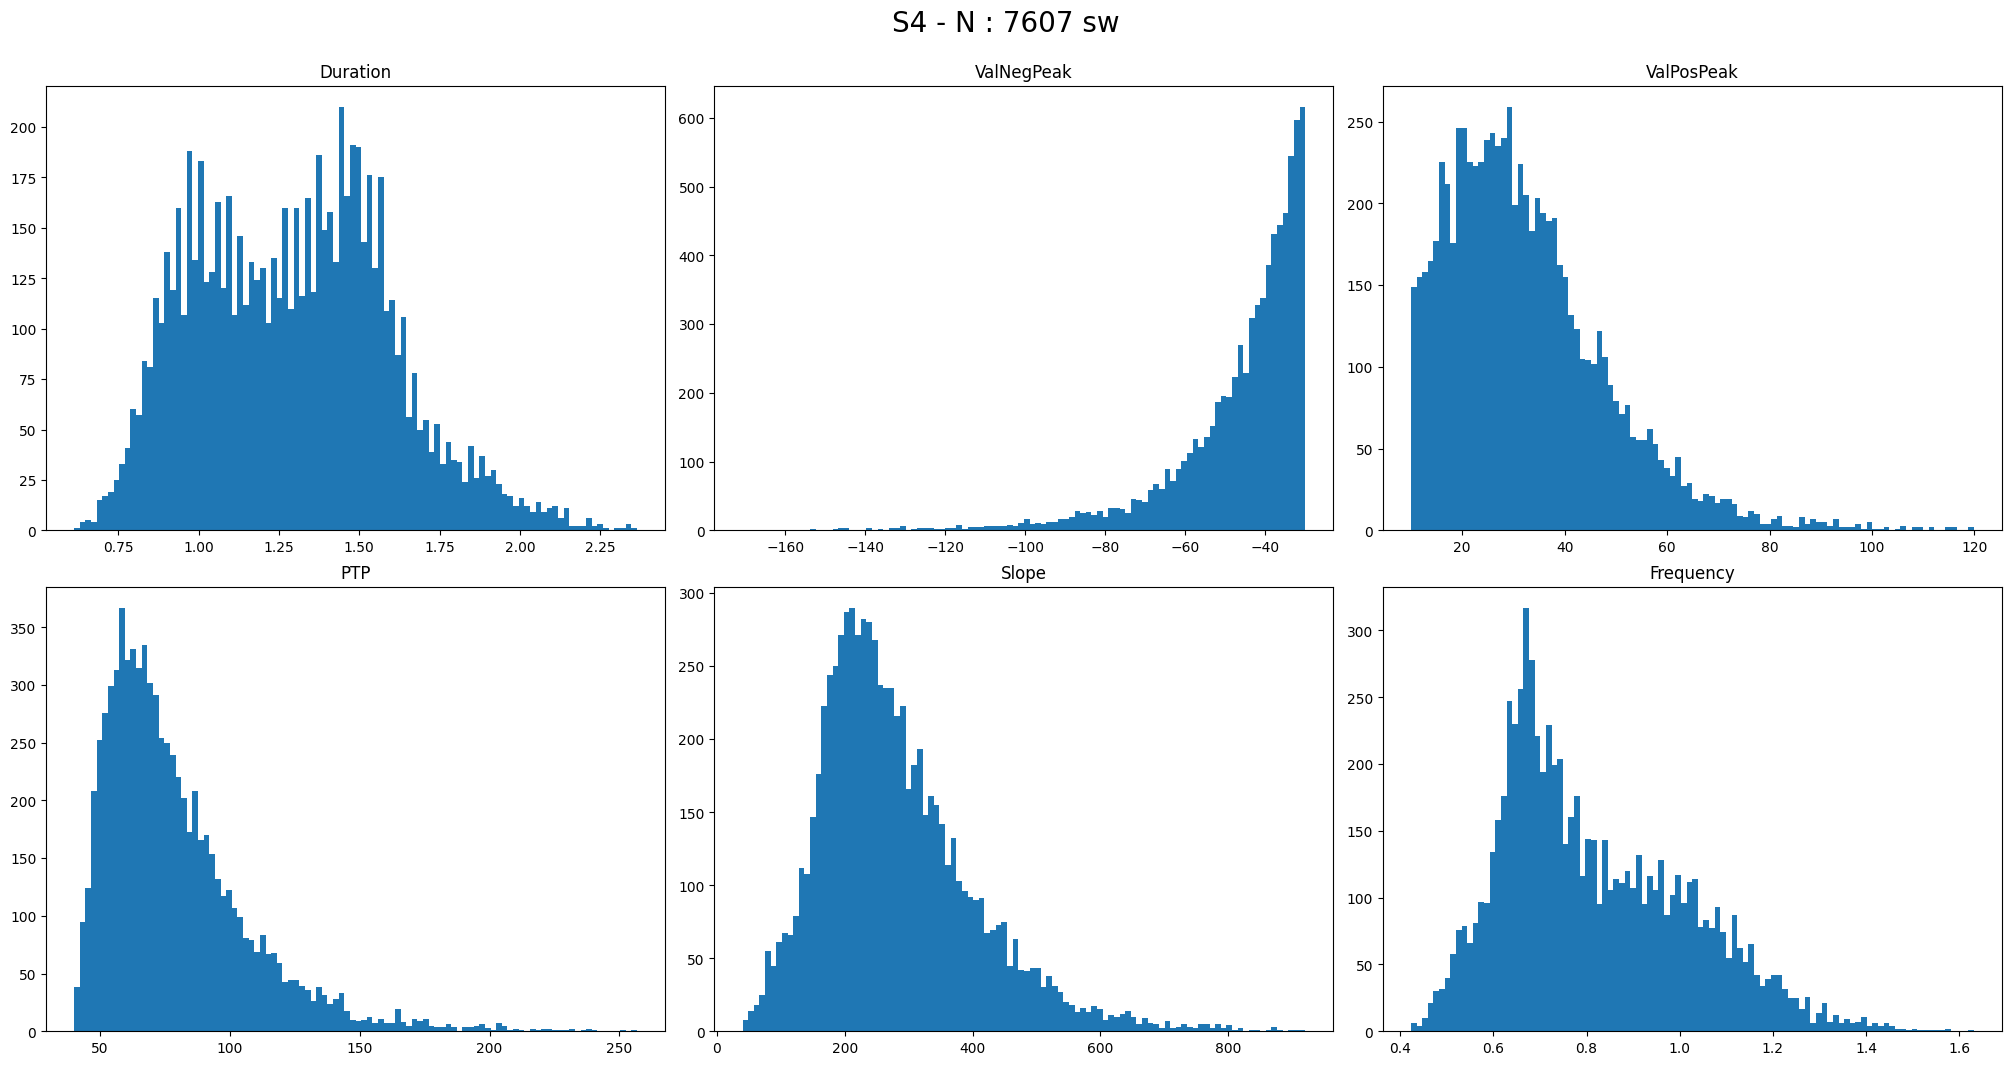

In [61]:
ev_features_to_include = {'sp':['Duration', 'Amplitude', 'RMS', 'AbsPower','RelPower', 'Frequency', 'Oscillations', 'Symmetry'],
'sw':['Duration','ValNegPeak', 'ValPosPeak', 'PTP', 'Slope', 'Frequency']}

event_type = 'sw'

N = sws.shape[0]

nrows = 2
if event_type == 'sp':
    ncols = 4
else:
    ncols = 3
ev_features_to_include_array = np.array(ev_features_to_include[event_type]).reshape(nrows,ncols)
fig, axs = plt.subplots(nrows, ncols, figsize = (20,10), constrained_layout = True)
fig.suptitle(f'{subject} - N : {int(N)} sw', fontsize = 20, y = 1.05)
for r in range(nrows):
    for c in range(ncols):
        ax = axs[r,c]
        metric = ev_features_to_include_array[r,c]
        ax.hist(sws[metric], bins = 100)
        ax.set_title(metric)
        if metric == 'Frequency' and event_type == 'sp':
            ax.axvline(x = spindles_freq_threshold[subject], color = 'r')
# plt.savefig(f'../events_stats/{subject}_{event_type}_distributions', bbox_inches = 'tight')
plt.show()